# Lab 8
This is a jupyter notebook for lab 8. First we will import some libraries and functions. 

Note that this doesn't work yet!

In [1]:
from eofs.standard import Eof
from eofs.examples import example_data_path
from numpy import genfromtxt
import numpy as np
from netCDF4 import MFDataset 
from netCDF4 import Dataset 
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
from datetime import datetime
from netCDF4 import num2date
from netCDF4 import date2index
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import cartopy.util as cutil
%matplotlib inline

Our next setep is to read in the netCDF files. 

In [2]:
ds = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc')
ds2 = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc')

Provide the pressure level and month you wish to utilize. Also provide the month as a string, so our caption is attractive.


In [3]:
plevel = 850
month = 1
monthlabel = 'January'
tm = int(month)-1

In [4]:
# Grab lat/lon values
lats = ds.lat.data[0:29]
lons = ds.lon.data

temp = ds.air.sel(level=plevel)[tm::12,0:29,:]
hght = ds2.hgt.sel(level=plevel)[tm::12,0:29,:]

In [5]:
#print (np.shape(temptest))
print(np.shape(temp))
print (np.shape(lats))
print (np.shape(lons))

(73, 29, 144)
(29,)
(144,)


Calculate EOFs!

In [6]:
coslat = np.cos(np.deg2rad(temp.coords['lat'].values)).clip(0., 1.)


print(coslat)
wgts = np.sqrt(coslat)[..., np.newaxis]

#solver for EOFs/PCs: initially set for 850 hPa T
solver = Eof(temp.values, weights=wgts)
#EOF calculation:leading 2 EOFs
eof1 = solver.eofsAsCorrelation(neofs=3)
#eof1 = solver.eofsAsCovariance(neofs=2)
pc1 = solver.pcs(npcs=3, pcscaling=1)
varianceexplained = solver.varianceFraction(neigs=10)


[0.         0.04361945 0.0871558  0.13052624 0.17364822 0.21643965
 0.25881907 0.30070582 0.34202015 0.38268346 0.42261827 0.4617486
 0.49999997 0.5372996  0.57357645 0.6087614  0.6427876  0.67559016
 0.70710677 0.7372773  0.76604444 0.7933533  0.81915206 0.8433914
 0.8660254  0.8870108  0.90630776 0.9238795  0.9396926 ]


Map time!

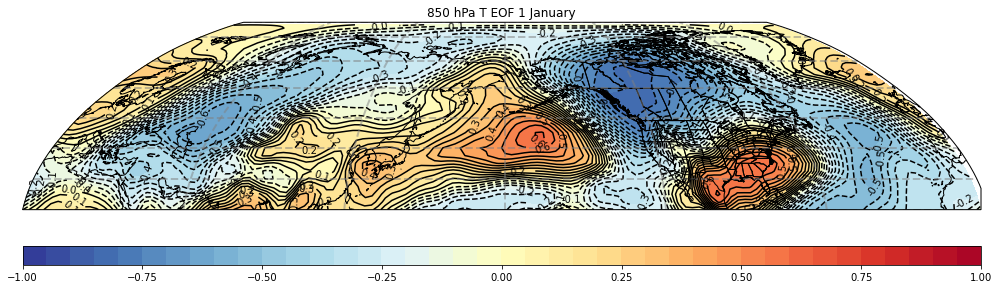

In [7]:
# Set up the projection that will be used for plotting
levels = np.arange(-1,1.05,0.05)

mapcrs = ccrs.Robinson(central_longitude=180)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

#not needed here, but used for sub-setting domain to plot
#ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
#plotting temperature and including color bar

cf = ax.contourf(lons, lats, eof1[0,:,:], levels, cmap=plt.cm.RdYlBu_r, transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
cs = ax.contour(lons, lats, eof1[0,:,:], levels, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%1.1f')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
#ax.barbs(lons[::4], lats[::4], uwnd.to('kt')[ty,::4,::4].m, 
#         vwnd.to('kt')[ty,::4,::4].m, pivot='middle',
#         color='black', transform=datacrs, length=5, linewidth=0.4)

# Make some nice titles for the plot (one right, one left)
plt.title('850 hPa T EOF 1 ' + str(monthlabel))

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig('850hPaTeof1' + str(monthlabel), dpi=150)
plt.show()

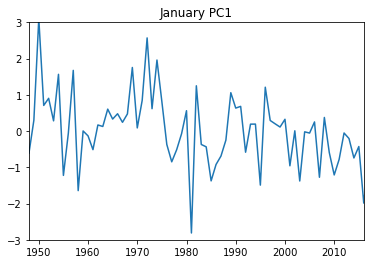

In [8]:
#Associated PC time series:
years = list(range(1948,1948+len(pc1[:,0])))
plt.plot(years,pc1[:,0])
plt.axis([1948,2016,-3,3])
plt.title(str(monthlabel) + ' ' +'PC1')
plt.show()

Histogram!

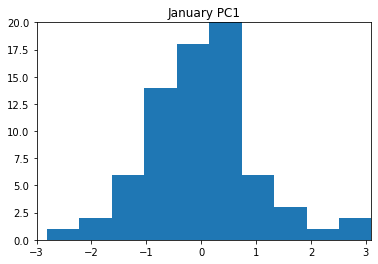

In [9]:
plt.hist(pc1[:,0])
plt.axis([-3,3.1,0,20])
plt.title(str(monthlabel) + ' ' +'PC1')
plt.show()

In [10]:
print ('pc np shape')
print (np.shape(pc1))
print (pc1[:,0])
print ('varianceexplained')
print (varianceexplained)
print (np.shape(eof1))

pc np shape
(73, 3)
[-0.6095982   0.30037478  3.1049376   0.70771974  0.9041364   0.28217065
  1.5661387  -1.2228694  -0.05924219  1.6750263  -1.6432115   0.0032406
 -0.13219734 -0.51258254  0.1685744   0.12708655  0.6056204   0.33182847
  0.47808293  0.24214661  0.47315574  1.7550293   0.08708034  0.8471898
  2.5708556   0.61764437  1.9604189   0.8078419  -0.36941952 -0.8481668
 -0.5147288  -0.07241105  0.56233156 -2.812007    1.2497894  -0.36933616
 -0.4348103  -1.3742296  -0.9217892  -0.6891154  -0.24901286  1.0593334
  0.63459414  0.68173516 -0.58347046  0.19117342  0.19275156 -1.4908994
  1.2107563   0.29265258  0.2006711   0.11142217  0.3257202  -0.9579007
  0.00788054 -1.3771986  -0.02056965 -0.0549419   0.2524303  -1.2746998
  0.37591708 -0.5926389  -1.2103783  -0.7816054  -0.05280609 -0.20511109
 -0.7416619  -0.42642525 -1.9873582  -0.77837336 -0.93760085 -0.53600603
 -0.12108251]
varianceexplained
[0.16142449 0.14745934 0.09486581 0.08351907 0.0646615  0.04847522
 0.04100579 

Plot the 2nd EOF!

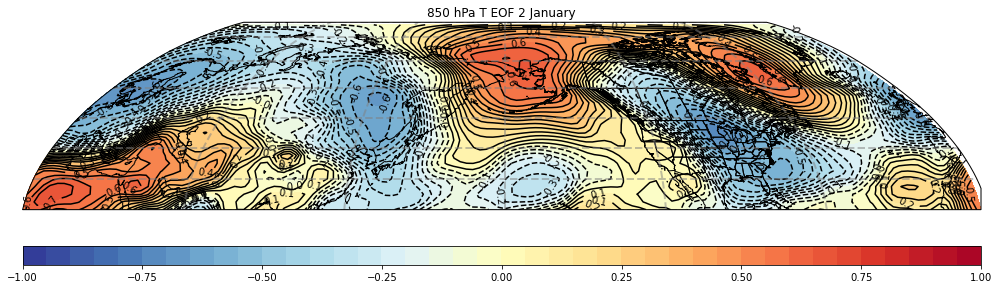

In [11]:
plt.figure(2,figsize=(14, 12))

# Set up the projection that will be used for plotting
levels = np.arange(-1,1.05,0.05)
mapcrs = ccrs.Robinson(central_longitude=180)
# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(2, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

#not needed here, but used for sub-setting domain to plot
#ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
#plotting temperature and including color bar

cf = ax.contourf(lons, lats, eof1[1,:,:], levels, cmap=plt.cm.RdYlBu_r, transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
cs = ax.contour(lons, lats, eof1[1,:,:], levels, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%1.1f')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
#ax.barbs(lons[::4], lats[::4], uwnd.to('kt')[ty,::4,::4].m, 
#         vwnd.to('kt')[ty,::4,::4].m, pivot='middle',
#         color='black', transform=datacrs, length=5, linewidth=0.4)

# Make some nice titles for the plot (one right, one left)
plt.title('850 hPa T EOF 2 ' + str(monthlabel))

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig('850hPaTeof2' + str(monthlabel), dpi=150)
plt.show()

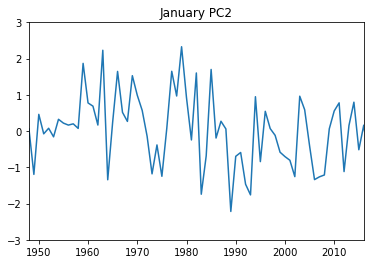

In [12]:
#Associated PC time series:
years = list(range(1948,1948+len(pc1[:,1])))
plt.plot(years,pc1[:,1])
plt.axis([1948,2016,-3,3])
plt.title(str(monthlabel) + ' ' +'PC2')
plt.show()

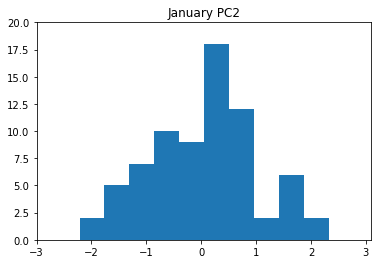

In [13]:
plt.hist(pc1[:,1])
plt.axis([-3,3.1,0,20])
plt.title(str(monthlabel) + ' ' +'PC2')
plt.show()

Write the PC time series to a file

In [14]:
outfile = open('850hPaTPC' + str(monthlabel)+'.csv','w')
outfile.writelines("Year   PC1      PC2 \n")
#outfile.writelines(str(pc1[:,0])+', '+str(pc1[:,1])+'\n')
for i in range(0,len(pc1)):
   outfile.writelines(str(years[i])+', '+str(pc1[i,0])+', '+str(pc1[i,1])+'\n')
outfile.close()


Read in NAO data, so we can see relationship with temperature PCs!

In [16]:
infile = open('mei.txt', 'r')
mei = infile.readlines()
print (np.shape(mei))

for i in range(len(mei)):
  mei[i] = mei[i].split()

mei = np.array(mei).astype('float')
print (np.shape(mei))

(69,)
(69, 13)


Scatterplot of the leading 850 hPa temperature PC with the NAO  

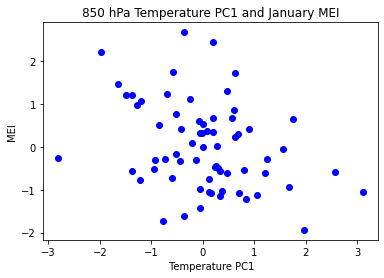

In [17]:
plt.plot(pc1[2:69,0],mei[2:69,1], 'bo')
#plt.axis([-2, 2, -2, 2])
plt.title('850 hPa Temperature PC1 and January MEI')
plt.xlabel(' Temperature PC1')
plt.ylabel('MEI')
plt.show()

In [18]:
print(np.corrcoef(pc1[2:69,0],mei[2:69,1])[1,0])

-0.32597421319477266
